In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import numba as nb

In [2]:
@jit(nopython=True)
def LV_compute(S, D, A, T, step, AA):

    N_mean = 1 / (S * A * np.sqrt(np.pi / 2))
    NN = np.zeros((T, S))
    r = np.ones(S)
    
    N0 = np.ones(S)*N_mean
    NN[0] = N0
    Migra = np.ones(S) * D

    for i in range(1, T):
        
        k1 = r * NN[i-1] * (1- np.dot(AA, NN[i-1]))* step
        k2 = r * (NN[i-1]+k1/2) * (1- np.dot(AA, NN[i-1]+k1/2))*step
        k3 = r * (NN[i-1]+k2/2) * (1- np.dot(AA, NN[i-1]+k2/2))*step
        k4 = r * (NN[i-1]+k3) * (1- np.dot(AA, NN[i-1]+k3))*step
        #NN[i] = NN[i-1] + r * NN[i-1] * (1- np.dot(AA, NN[i-1])) * step
        NN[i] = NN[i-1]+ (k1+2*k2+2*k3+k4)/6
        NN[i] += Migra  # 添加迁移

    return NN

In [3]:
# 参数定义
r_mean = 1.0  # 平均增长率
S = 50
DD = 1e-6  # 迁移率
A_mean_range = [0.01, 1]  # 平均抑制系数范围
ystep = 20  # A_mean 的步数
T_real = 1000  # 总进化时间
step = 0.05  # 时间间隔
T = int(np.ceil(T_real / step))  # 循环次数
num_sim = 10  # 系综平均次数
period = 200  # 用于计算丰富度的持续时间
abundance_threshold = 1e-3  # 物种生存的丰度阈值

In [4]:
@jit(nopython=True)
def axis_of_cols(matrix, num_cols):
    maxc = np.zeros(num_cols)
    flucc= np.zeros(num_cols)
    matrix_2 = matrix.T
    richness =0
    
    for i in range(num_cols):       
        maxc[i] =  np.max(matrix_2[i][500-period:500])
        if maxc[i]> abundance_threshold:
            richness+=1
            mean_v = np.mean(matrix_2[i])
            if mean_v!=0 and not np.isnan(np.std(matrix_2[i]) /mean_v):
                flucc[i] = np.std(matrix_2[i]) /mean_v

    return  richness, flucc

In [5]:
A_mean = np.linspace(A_mean_range[0], A_mean_range[1], ystep)

In [6]:
# 初始化记录矩阵
num_sim = 1000

fluc_record_1d = np.zeros(( ystep, num_sim))
diversity_record_1d = np.zeros(( ystep, num_sim))
fluc_mean_1d = np.zeros(( ystep))
div_mean_1d = np.zeros(( ystep))
AA_record = np.zeros((ystep, num_sim,S,S))
for pp in range(ystep):
    print("A=", A_mean[pp])
    for hh in range(num_sim):
        # 调用 LV_compute 函数来计算组成
        AA = np.random.randn(S, S)*A_mean[pp]/2 +A_mean[pp]
        AA = np.abs(AA)
        AA = AA - np.diag(np.diag(AA)) + np.eye(S)  # 对角线元素设为 1
        composition = LV_compute(50, DD, A_mean[pp], T, step, AA)
        richness,fluc_CV = axis_of_cols(composition[T - 500:T], 50)
        diversity_record_1d[pp, hh] = richness / 50
        fluc_record_1d[pp, hh] = np.sum(fluc_CV)/ richness
        AA_record[pp,hh] = AA
    div_mean_1d[pp] = np.mean(diversity_record_1d[pp])
    fluc_mean_1d[pp]= np.sum(fluc_record_1d[pp]*diversity_record_1d[pp])/np.sum(diversity_record_1d[pp])

A= 0.01
A= 0.06210526315789474
A= 0.11421052631578947
A= 0.16631578947368422
A= 0.21842105263157896
A= 0.2705263157894737
A= 0.32263157894736844
A= 0.37473684210526315
A= 0.4268421052631579
A= 0.4789473684210527
A= 0.5310526315789474
A= 0.5831578947368421
A= 0.6352631578947369
A= 0.6873684210526316
A= 0.7394736842105263
A= 0.791578947368421
A= 0.8436842105263158
A= 0.8957894736842106
A= 0.9478947368421053
A= 1.0


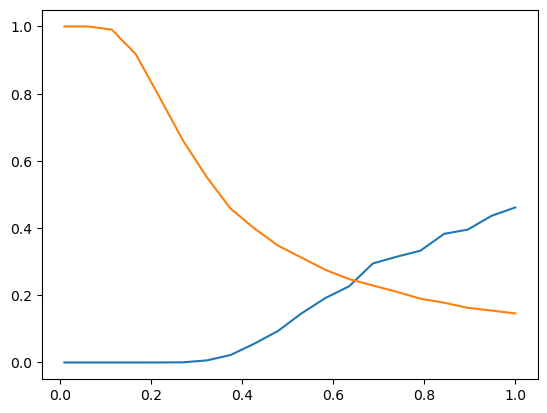

In [7]:
plt.plot(A_mean,fluc_mean_1d)
plt.plot(A_mean,div_mean_1d)

(array([  0.,   0.,   0.,   1.,  10.,  24.,  31., 128.,  81., 199.,  75.,
        155.,  49.,  60.,  65.,  23.,  53.,  13.,  21.,   3.,   4.,   2.,
          1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.]),
 array([0.        , 0.02857143, 0.05714286, 0.08571429, 0.11428571,
        0.14285714, 0.17142857, 0.2       , 0.22857143, 0.25714286,
        0.28571429, 0.31428571, 0.34285714, 0.37142857, 0.4       ,
        0.42857143, 0.45714286, 0.48571429, 0.51428571, 0.54285714,
        0.57142857, 0.6       , 0.62857143, 0.65714286, 0.68571429,
        0.71428571, 0.74285714, 0.77142857, 0.8       , 0.82857143,
        0.85714286, 0.88571429, 0.91428571, 0.94285714, 0.97142857,
        1.        ]),
 <BarContainer object of 35 artists>)

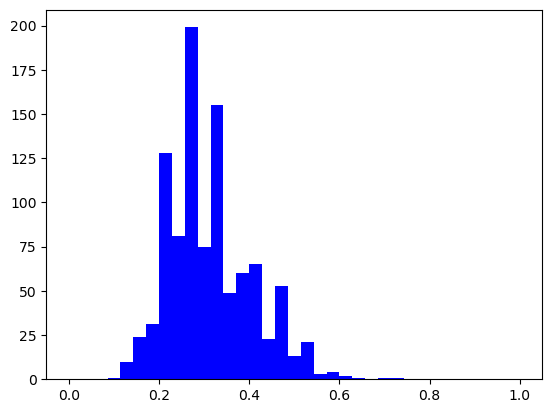

In [8]:
plt.hist(diversity_record_1d[10], bins=35, range=(0,1), alpha=1, color='b')

(array([536.,  31.,  20.,  25.,  19.,  23.,  33.,  38.,  40.,  38.,  36.,
         33.,  31.,  27.,  25.,  17.,  13.,  11.,   2.,   1.]),
 array([0.  , 0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.48, 0.54, 0.6 ,
        0.66, 0.72, 0.78, 0.84, 0.9 , 0.96, 1.02, 1.08, 1.14, 1.2 ]),
 <BarContainer object of 20 artists>)

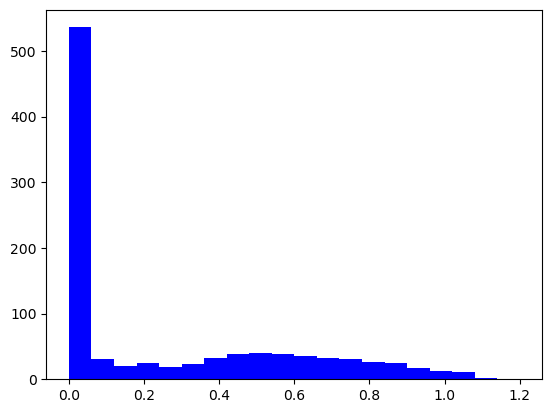

In [9]:
plt.hist(fluc_record_1d[16], bins=20, range=(0,1.2), alpha=1, color='b')

In [10]:
print(np.shape(fluc_record_1d))

(20, 1000)


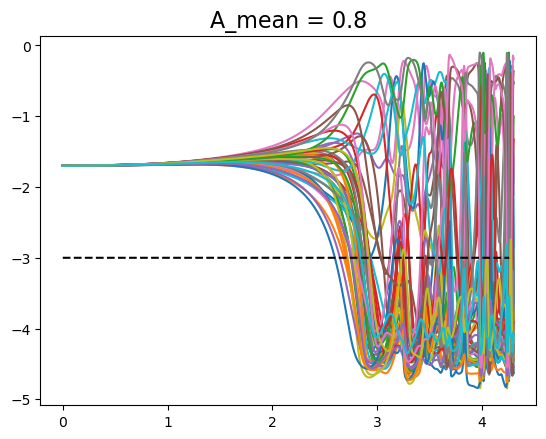

In [30]:
A_s = 0.8
AA = np.random.randn(S, S)*A_s/2 +A_s
AA = np.abs(AA)
AA = AA - np.diag(np.diag(AA)) + np.eye(S)  # 对角线元素设为 1
composition = LV_compute(50, DD, A_s, T, step, AA)

x_zhou = np.arange(T)
y_zhou = -3*np.ones(T)

plt.figure()
plt.title('A_mean = {}'.format(A_s), fontsize=16)
for i in range(S):
    plt.plot(np.log(x_zhou+1)*0.4343,np.log(composition.T[i])*0.4343)

plt.plot(np.log(x_zhou+1)*0.43,y_zhou,linestyle='--', color = 'black')

In [31]:
np.save('diversity_record_1d_111.npy', diversity_record_1d)
np.save('fluc_record_1d_111.npy', fluc_record_1d)
np.save('div_mean_111.npy',div_mean_1d)
np.save('fluc_mean_111.npy',fluc_mean_1d)
np.save('AA_record_111.npy', AA_record)
np.save('A_mean_111.npy',A_mean)